In [9]:
import numpy as np
import numba
import librosa
import librosa.display
%matplotlib nbagg
import mir_eval.sonify
from IPython.display import Audio
import matplotlib.pyplot as plt


In [10]:
def compute_novelty_log_energy(y, fs, win_size=1024, hop_size=256):
    """ Compute the log energy derivative novelty function to be used for onset detection
    Parameters
    ----------
    y : ndarray
    (T,) mono time domain signal
    fs : int
    sample rate of y (samples per second)
    win_size : int default=1024
    window size (in samples)
    hop_size : int default=256
    hop size (in samples)
    
    Returns
    -------
    novelty : ndarray
    (L,) novelty funciton
    times : ndarray
    (L,) time posts for novelty function
    fs_novelty : float
    sample rate of novelty function
    """
    energy = y ** 2
    energy_mat = librosa.util.frame(y=energy, frame_length=win_size, hop_length=hop_size)
    
    # windowing
    windowing_mat = np.diag(np.hanning(win_size))
    energy_mat_windowed = np.dot(windowing_mat, energy_mat)

    # computer log energy derivative
    energy_mean = np.mean(energy_mat_windowed, axis=0)
    log_mean_eng = np.log(energy_mean)
    log_energy_derivative = np.diff(log_mean_eng)
    
    # output gathering
    novelty = log_energy_derivative / np.max(log_energy_derivative) # normalize
    fs_novelty = float(fs) / hop_size
    times = np.array([float(i) / fs_novelty for i in range(len(novelty))])
    
    return novelty, times, fs_novelty

In [37]:
def compute_novelty_spec_flux(y, fs, hop_size=256):
    """ Compute novelty function using spectural flux.
    Parameters
    ----------
    y : ndarray
    (T,) mono time domian signal
    fs : int
    sample rate of y
    win_size : int
    hop_size : int
    
    Returns
    -------
    novelty : ndarray
    times : ndarray
    fs_novelty : float
    """
    S = librosa.feature.melspectrogram(y=y, sr=fs, n_mels=256, hop_length=hop_size)
    S_dB = librosa.power_to_db(S, ref=np.max)
    dS_dt = np.diff(S,axis=1)
    # HW Rectify dS_dt
    for x in np.nditer(dS_dt, op_flags=['readwrite']):
        x[...] = max(x,0)
    # 
    
    weight_vec = np.append( np.zeros(128), np.ones(128))
    weight_vec += 1
    
    weighted_sf = np.dot(np.diag(weight_vec), dS_dt)
    
    # output gathering
    novelty = np.mean(weighted_sf, axis=0)
    fs_novelty = float(fs) / hop_size
    times = np.array([float(i) / fs_novelty for i in range(len(novelty))])
    
    return novelty, times, fs_novelty

def compute_novelty_spec_flux_offset(y, fs, hop_size=256):
    """ Compute novelty function using spectural flux, but for offset, so negate and then HWR
    Parameters
    ----------
    y : ndarray
    (T,) mono time domian signal
    fs : int
    sample rate of y
    win_size : int
    hop_size : int
    
    Returns
    -------
    novelty : ndarray
    times : ndarray
    fs_novelty : float
    """
    S = librosa.feature.melspectrogram(y=y, sr=fs, n_mels=256, hop_length=hop_size)
    S_dB = librosa.power_to_db(S, ref=np.max)
    dS_dt = np.diff(S,axis=1)
    # negate and HW Rectify dS_dt
    for x in np.nditer(dS_dt, op_flags=['readwrite']):
        x[...] = max(-x,0)
    # 
    
    weight_vec = np.append( np.zeros(128), np.ones(128))
    weight_vec += 1
    
    weighted_sf = np.dot(np.diag(weight_vec), dS_dt)
    
    # output gathering
    novelty = np.mean(weighted_sf, axis=0)
    fs_novelty = float(fs) / hop_size
    times = np.array([float(i) / fs_novelty for i in range(len(novelty))])
    
    return novelty, times, fs_novelty

In [116]:
from scipy import signal

def medfilt(x, k):
    """Apply a length-k median filter to a 1D array x.
    Boundaries are extended by repeating endpoints.
    """
    assert k % 2 == 1, "Median filter length must be odd."
    assert x.ndim == 1, "Input must be one-dimensional."
    k2 = (k - 1) // 2
    y = np.zeros ((len (x), k), dtype=x.dtype)
    y[:,k2] = x
    for i in range (k2):
        j = k2 - i
        y[j:,i] = x[:-j]
        y[:j,i] = x[0]
        y[:-j,-(i+1)] = x[j:]
        y[-j:,-(i+1)] = x[-1]
    return np.median (y, axis=1)

def onsets_from_novelty(novelty, times, fs, w_c=3, medfilt_len=11, offset=0.001):
    # smoothing using butterworth and normalize
    nyq = fs / 2.0
    B, A = signal.butter(1, w_c / nyq, 'low')
    novelty_smoothed = signal.filtfilt(B, A, novelty)
    novelty_smoothed = novelty_smoothed / np.max(np.abs(novelty_smoothed))
    
    # adaptive thresholding
    thresh = medfilt(novelty_smoothed, medfilt_len) + offset
    
    # onset detection
    peak_idx = librosa.util.peak_pick(novelty_smoothed, 3, 3, 3, 5, 0.001, 10)
    
    pruned_peak_idx = []
    for p_idx in peak_idx:
        if novelty_smoothed[p_idx] > thresh[p_idx]: # it made it
            pruned_peak_idx.append(p_idx)
    return pruned_peak_idx, novelty_smoothed, thresh

In [117]:

# y, fs = librosa.load('/Users/tom/Desktop/eh_BN1-129-Eb_c_hex_cln_03.wav', sr=None)
# y, fs = librosa.load('/Users/tom/Music/DataSet/test_set_annotated1/js_SS2-107-Ab_c/02_D_ghex_mira_mode-1_preset-js_SS2-107-Ab_c.wav', sr=None)
y, fs = librosa.load('/Users/tom/Music/DataSet/test_set_annotated1/vl_Jazz2-110-Bb_c/04_B_ghex_mira_mode-1_preset-vl_Jazz2-110-Bb_c.wav', sr=None)

y = y / np.max(np.abs(y))
y_harm, y_perc = librosa.effects.hpss(y)
print(np.max(np.abs(y)))

1.0


In [118]:
sf, times, fs_novelty = compute_novelty_spec_flux(y, fs)
sf_perc, times_on, fs_novelty_on = compute_novelty_spec_flux(y_perc, fs)
sf_offset_harm, times_off, fs_novelty_off = compute_novelty_spec_flux_offset(y_harm, fs)

In [122]:
pruned_peak_idx_on, novelty_smoothed_on, thresh_on = onsets_from_novelty(sf, times_on, fs_novelty_on)
pruned_peak_idx_off, novelty_smoothed_off, thresh_off = onsets_from_novelty(sf, times_off, fs_novelty_off)

<IPython.core.display.Javascript object>


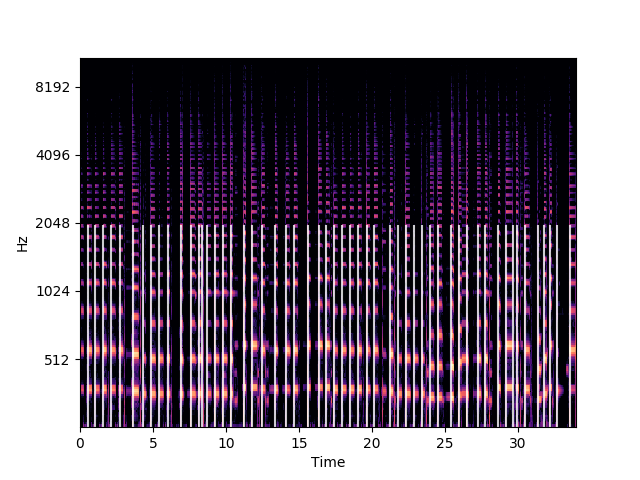

In [123]:
import librosa.display


plt.figure()
S = librosa.feature.melspectrogram(y=y, sr=fs, n_mels=256)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', sr=fs, x_axis='time')
plt.vlines(times_on[pruned_peak_idx_on], 0, 2000, color='w', alpha=0.8, label='Onsets')
# plt.vlines(times_off[pruned_peak_idx_off], 1000, 3000, color='r', alpha=0.8, label='Offsets')
plt.show()


In [121]:
onset_times = [times_on[idx] for idx in pruned_peak_idx_on]
offset_times = [times_off[idx] for idx in pruned_peak_idx_off]
y_onset_son = librosa.core.clicks(times=onset_times, sr=fs, hop_length=512, click_freq=2000.0, click_duration=0.1, click=None, length=len(y))
y_offset_son = librosa.core.clicks(times=offset_times, sr=fs, hop_length=512, click_freq=2500.0, click_duration=0.1, click=None, length=len(y))
Audio(data=y_onset_son + y * 2, rate=fs)